In [1]:
import numpy as np
import pandas as pd
import pickle
from utils import load_basque_data, decompose_Y, generate_simulation_components, parallel_experiments

In [2]:
data_dict = {}
RMSE = {}
bias = {}

# set n_jobs to the number of cores
num_cores = 36
num_experiments = 100

## Load and Format Data

In [38]:
# configs = {'Simulated': ['gdpcap', None, None],
#            'Random': ['gdpcap', None, 'Random']
#           }

# TROP_dict = {'Simulated': [0, 0.35, 0.0061],
#     'Random': [0, 0.35, 0.0061]
#             }

configs = {
           'Random': ['gdpcap', None, 'Random']
          }

TROP_dict = {
    'Random': [1.2, 0.3, 0.005]
            }

for setting, config in configs.items():
    
    print(setting)
    
    # load and process data for each setting
    outcome, treatment, option = config
    data = load_basque_data(outcome, treatment)
    data_dict[setting] = data
    
    # run simulations
    simulation_components = generate_simulation_components(data, sc_weights=False)
    np.random.seed(0)
    RMSE[setting], bias[setting] = parallel_experiments(num_cores, num_experiments, simulation_components, TROP_dict[setting], option)

Random


In [39]:
RMSE

{'Random': array([0.08831005, 0.1390276 , 0.23460153, 0.32885369, 0.1394039 ,
        0.13940372])}

In [40]:
np.array([0.05052689, 0.07919196, 0.10781517, 0.15592902, 0.06607513,
        0.08465485])/0.051

array([0.99072333, 1.55278353, 2.11402294, 3.05743176, 1.29559078,
       1.65989902])

# Optimal Tuning Parameter

In [3]:
from methods import TROP_TWFE_average
from utils import generate_data
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [4]:
np.random.seed(1)
outcome, treatment, option = ['gdpcap', None, 'Random']
data = load_basque_data(outcome, treatment)
F, M, cov_mat, pi = generate_simulation_components(data, sc_weights=False)

In [5]:
#Y_true, _, _, _ = generate_data(F, M, cov_mat, pi, option)
treated_periods = 10
treated_unit_number = 1

In [6]:
def get_ATE(trial, lambda_unit, lambda_time, lambda_nn):
    np.random.seed(trial)
    Y_true, _, treated_units, _ = generate_data(F, M, cov_mat, pi, option)
    
    Y_true = np.delete(Y_true, treated_units, axis=0)
    N_total, _ = Y_true.shape
    test_units = np.random.choice(np.arange(N_total), size=treated_unit_number,replace=False)
    #test_units = np.arange(N_total)
    
    W_test = np.zeros(Y_true.shape)
    W_test[test_units,-treated_periods:] = 1
    estimate = TROP_TWFE_average(Y_true,W_test, test_units,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn, treated_periods=treated_periods)
    return estimate

## Select lambda_unit

In [29]:
Q = []
lambda_units = np.arange(0,3,3/10)
for lambda_unit in lambda_units:
    lambda_time = 0.3
    lambda_nn = 0.005
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0.0 0.3 0.005
0.08246153179430152
0.3 0.3 0.005
0.08368878181800025
0.6 0.3 0.005
0.08325656646768913
0.8999999999999999 0.3 0.005
0.0814536164323117
1.2 0.3 0.005
0.08045929260738194
1.5 0.3 0.005
0.08135926811635179
1.7999999999999998 0.3 0.005
0.08358807458016969
2.1 0.3 0.005
0.08645132323026267
2.4 0.3 0.005
0.08953805358998572
2.6999999999999997 0.3 0.005
0.09264498036771146


In [30]:
lambda_units[np.argmin(Q)]

1.2

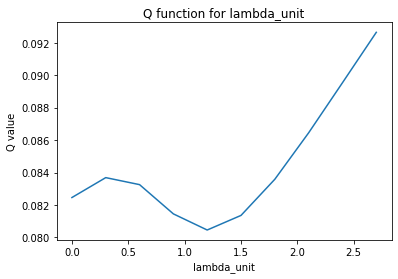

In [31]:
plt.plot(lambda_units,Q)
plt.xlabel('lambda_unit')
plt.ylabel('Q value')
plt.title('Q function for lambda_unit')
plt.show()

## Select lambda_time

In [32]:
Q = []
lambda_times = np.arange(0,0.5,0.5/10)
for lambda_time in lambda_times:
    lambda_nn = 0.005
    lambda_unit = 1.2
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

1.2 0.0 0.005
0.1276669682561021
1.2 0.05 0.005
0.138545937484848
1.2 0.1 0.005
0.16005812131510663
1.2 0.15000000000000002 0.005
0.12998029489859522
1.2 0.2 0.005
0.10632468594825646
1.2 0.25 0.005
0.0887724126317628
1.2 0.30000000000000004 0.005
0.08045929260727168
1.2 0.35000000000000003 0.005
0.08511325743922103
1.2 0.4 0.005
0.09809107308123614
1.2 0.45 0.005
0.11207184377576909


In [33]:
lambda_times[np.argmin(Q)]

0.30000000000000004

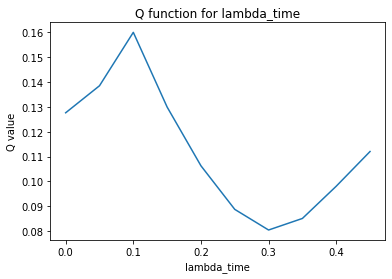

In [34]:
plt.plot(lambda_times,Q)
plt.xlabel('lambda_time')
plt.ylabel('Q value')
plt.title('Q function for lambda_time')
plt.show()

### Select lambad_nn

In [35]:
Q = []
lambda_nns = np.arange(0.005,0.055,0.05/10)
for lambda_nn in lambda_nns:
    lambda_time = 0.3
    lambda_unit = 1.2
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

1.2 0.3 0.005
0.08045929260738194
1.2 0.3 0.01
0.088979594328808
1.2 0.3 0.015
0.09897581481323331
1.2 0.3 0.02
0.10733947514180633
1.2 0.3 0.025
0.11411888460038454
1.2 0.3 0.030000000000000002
0.11965311139306414
1.2 0.3 0.034999999999999996
0.12417927789549361
1.2 0.3 0.04
0.12793066393088473
1.2 0.3 0.045
0.130992919293341
1.2 0.3 0.049999999999999996
0.1334397403280576


In [36]:
lambda_nns[np.argmin(Q)]

0.005

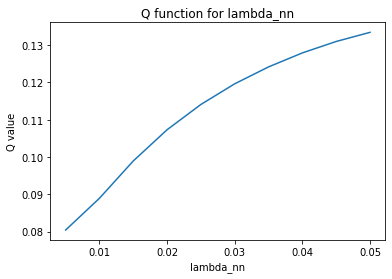

In [37]:
plt.plot(lambda_nns,Q)
plt.xlabel('lambda_nn')
plt.ylabel('Q value')
plt.title('Q function for lambda_nn')
plt.show()